### PS-11 Intel Products Sentiment Analysis from Online Reviews

##### Team Name: Fractals
##### Members: Aviral Srivastava, Garv Bhaskar, Dinesh Kumar
##### Institution: Vellore Institute of Technology, Chennai

### Table of Contents
* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)
* #### [Part 7. Summary Generation](#part7)
* #### [Part 8. Predictions](#part8)




In [3]:
import os

amazon_dir = './amazon'
os.chdir(amazon_dir)


In [ ]:
!scrapy crawl amaze
#Will take time to run and make the dataset data.csv
#Wait until cell is run completely!!!!!!!

In [5]:

os.chdir('..')

---
<a id="part1"></a>
## Part 1. Data Exploration

In [108]:
import pandas as pd
import numpy as np
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.tokenize import PunktSentenceTokenizer  

import logging
import langdetect

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda, Embedding, LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from tensorflow.keras.layers import Conv1D  # Use Conv1D instead of Convolution1D
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow import keras
from keras import regularizers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


### Load Data

In [109]:
# Load csv file
df = pd.read_csv('./amazon/data.csv')
df.head(4)

,Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack,Unnamed: 1,5.0,Reviewed in the United States on 17 September 2023,Omar Mendoza,Fast.
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,NaN,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...


In [110]:
df = df.drop(columns=["Unnamed: 1"])
df.head()

,Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack,5.0,Reviewed in the United States on 17 September 2023,Omar Mendoza,Fast.
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...


In [111]:
df.columns = ["Product", "Rating", "Demographic", "Reviewer", "Comments"]
df

,Product,Rating,Demographic,Reviewer,Comments
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...
...,...,...,...,...,...
110996,Intel Bx80673I97940X CPU Grey,1.0,Reviewed in India on 17 June 2020,Santhosh Philip,Not at all working fake one
110997,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Italy on 19 November 2018,Cliente Amazon,Un mostro di processore
110998,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Germany on 2 July 2018,Henning,Zum Schneiden und Bearbeiten bestens geeignet....
110999,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Spain on 20 May 2019,Latinmau,Puro poder de procesador. Honestamente para lo...


In [112]:
df[['Location', 'Date']] = df['Demographic'].str.extract(r'Reviewed in (.*?) on (.*)')

df = df.drop(columns=["Demographic", "Reviewer"])

df.columns = ["Product", "Rating", "Reviews", "Location", "Date"]
df

,Product,Rating,Reviews,Location,Date
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Fast.,the United States,17 September 2023
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,This processor is absolutely incredible with n...,India,3 September 2023
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Most powerful cpu at this price bracket no dou...,India,28 March 2023
...,...,...,...,...,...
110996,Intel Bx80673I97940X CPU Grey,1.0,Not at all working fake one,India,17 June 2020
110997,Intel Bx80673I97940X CPU Grey,5.0,Un mostro di processore,Italy,19 November 2018
110998,Intel Bx80673I97940X CPU Grey,5.0,Zum Schneiden und Bearbeiten bestens geeignet....,Germany,2 July 2018
110999,Intel Bx80673I97940X CPU Grey,5.0,Puro poder de procesador. Honestamente para lo...,Spain,20 May 2019


In [113]:
distinct_values = df["Product"].unique()

print("Distinct values in Column1:")
for value in distinct_values:
    print(value)

Distinct values in Column1:
Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack
Intel Core i7-13700K Desktop Processor 16 cores (8 P-cores + 8 E-cores) 30M Cache, up to 5.4 GHz Socket LGA 1700
Intel Core i7 (12th Gen) i7-12700 Dodeca-core (12 Core) 2.10 GHz Processor - Retail Pack
Intel Core i9-13900K Desktop Processor LGA 1700 24 cores (8 P-cores + 16 E-cores) 36M Cache, up to 5.8 GHz'
Intel Core i7-13700KF Gaming Desktop Processor 16 cores (8 P-cores + 8 E-cores) - Unlocked
Intel® Core™ i9-13900KS Processor 36M Cache, up to 6.00 GHz
Intel® Core™ i9-14900KS Desktop Processor 24 cores (8 P-cores + 16 E-cores)
Intel CM8070104291318 Core I3-10100f 3.6ghz Lga1200 Chip Tray Cpu Mm 999wpa
Intel Core i9-12900K Desktop Processor16 (8P+8E) Cores up to 5.2 GHz Unlocked LGA1700 600 Series Chipset 125W
Intel Core i7 12700F 12 Gen Desktop PC Processor 12 Core CPU with 25MB Cache and up to 4.9 GHz Clock Speed LGA 1700 4K (Graphic Card Required)
Intel Core I5 

In [114]:
def extract_info(row):
    # Split the text by spaces
    parts = row.split()
    # Extract relevant information
    brand = parts[0]
    try:
        # Extracting model till 'Processor' for processors
        if 'Processor' in row:
            model = ' '.join(parts[1:parts.index('Processor')])
        else:
            model = 'N/A'
    except ValueError:
        # If the keyword is not found, set model as N/A
        model = 'N/A'
    return pd.Series([brand, model])

# Apply the function to the DataFrame and concatenate the results
df[['Brand', 'Model']] = df['Product'].apply(extract_info)

# Drop the original column
df.drop('Product', axis=1, inplace=True)

# Display the resulting DataFrame
print(df)

        Rating                                            Reviews  \
0          5.0  Fast CPU and since I did not need the graphics...   
1          5.0                                              Fast.   
2          5.0  Fast CPU and since I did not need the graphics...   
3          5.0  This processor is absolutely incredible with n...   
4          5.0  Most powerful cpu at this price bracket no dou...   
...        ...                                                ...   
110996     1.0                        Not at all working fake one   
110997     5.0                            Un mostro di processore   
110998     5.0  Zum Schneiden und Bearbeiten bestens geeignet....   
110999     5.0  Puro poder de procesador. Honestamente para lo...   
111000     5.0  Für Videoschnitt in Verbindung mit Wasserkühlu...   

                 Location               Date  Brand  \
0       the United States  27 September 2022  Intel   
1       the United States  17 September 2023  Intel   
2     

In [115]:
# Remove rows where Model is 'N/A'
df = df[df['Model'] != 'N/A']

# Standardize the Brand column
df['Brand'] = df['Brand'].str.replace('Intel®', 'Intel', regex=False)
df['Brand'] = df['Brand'].str.replace('INTEL', 'Intel', regex=False)

# Remove rows where Model is 'N/A'
df = df[df['Model'] != 'N/A']

# Remove rows where Brand doesn't come under Intel
df = df[df['Brand'] == 'Intel']

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df

C:\Users\garvb\AppData\Local\Temp\ipykernel_10792\1754357483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Brand'] = df['Brand'].str.replace('Intel®', 'Intel', regex=False)
C:\Users\garvb\AppData\Local\Temp\ipykernel_10792\1754357483.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Brand'] = df['Brand'].str.replace('INTEL', 'Intel', regex=False)


,Rating,Reviews,Location,Date,Brand,Model
0,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
1,5.0,Fast.,the United States,17 September 2023,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
2,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
3,5.0,This processor is absolutely incredible with n...,India,3 September 2023,Intel,Core i7-13700K Desktop
4,5.0,Most powerful cpu at this price bracket no dou...,India,28 March 2023,Intel,Core i7-13700K Desktop
...,...,...,...,...,...,...
66488,5.0,the review is good anyway being an intel produ...,India,14 July 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
66489,5.0,"good service by amazon, my pros. k380 , deepc...",India,4 December 2015,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
66490,5.0,"Ultra fast 6th gen skylake processor , great f...",India,18 March 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
66491,5.0,I have used several older models of NUC before...,the United States,11 July 2023,Intel,NUC 13 Pro NUC13ANHi7 Barebone System - Socket...


In [116]:
# Function to extract Core series (i3, i5, i7, i9)
def extract_core_series(model):
    match = re.search(r'i[3579]', model)
    return match.group() if match else 'N/A'

# Function to extract generation
def extract_generation(model):
    match = re.search(r'i[3579]-(\d{4})|i[3579] (\d{4})', model)
    if match:
        return int(match.group(1) or match.group(2)) // 100
    return 'N/A'

# Apply the functions to create new columns using .loc
df.loc[:, 'Core_Series'] = df['Model'].apply(extract_core_series)
df.loc[:, 'Generation'] = df['Model'].apply(extract_generation)

# Remove rows where Core_Series or Generation is 'N/A'
df = df[(df['Core_Series'] != 'N/A') & (df['Generation'] != 'N/A')]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df


,Rating,Reviews,Location,Date,Brand,Model,Core_Series,Generation
0,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,i9,12
1,5.0,Fast.,the United States,17 September 2023,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,i9,12
2,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,i9,12
3,5.0,This processor is absolutely incredible with n...,India,3 September 2023,Intel,Core i7-13700K Desktop,i7,13
4,5.0,Most powerful cpu at this price bracket no dou...,India,28 March 2023,Intel,Core i7-13700K Desktop,i7,13
...,...,...,...,...,...,...,...,...
55276,5.0,Intel Core i7 6700K is a beast.,India,1 August 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,i7,67
55277,5.0,I bought this over 7700k cuz I could still ove...,India,9 February 2017,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,i7,67
55278,5.0,the review is good anyway being an intel produ...,India,14 July 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,i7,67
55279,5.0,"good service by amazon, my pros. k380 , deepc...",India,4 December 2015,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,i7,67


In [117]:
# Rearrange the columns
df = df[['Brand', 'Core_Series', 'Generation','Model', 'Rating', 'Date', 'Location','Reviews']]
df

,Brand,Core_Series,Generation,Model,Rating,Date,Location,Reviews
0,Intel,i9,12,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,27 September 2022,the United States,Fast CPU and since I did not need the graphics...
1,Intel,i9,12,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,17 September 2023,the United States,Fast.
2,Intel,i9,12,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,27 September 2022,the United States,Fast CPU and since I did not need the graphics...
3,Intel,i7,13,Core i7-13700K Desktop,5.0,3 September 2023,India,This processor is absolutely incredible with n...
4,Intel,i7,13,Core i7-13700K Desktop,5.0,28 March 2023,India,Most powerful cpu at this price bracket no dou...
...,...,...,...,...,...,...,...,...
55276,Intel,i7,67,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,1 August 2016,India,Intel Core i7 6700K is a beast.
55277,Intel,i7,67,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,9 February 2017,India,I bought this over 7700k cuz I could still ove...
55278,Intel,i7,67,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,14 July 2016,India,the review is good anyway being an intel produ...
55279,Intel,i7,67,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,4 December 2015,India,"good service by amazon, my pros. k380 , deepc..."


In [118]:
distinct_values = df["Model"].unique()

print("Distinct Processors being evaluated:")
for value in distinct_values:
    print(value)

Distinct Processors being evaluated:
Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz
Core i7-13700K Desktop
Core i7 (12th Gen) i7-12700 Dodeca-core (12 Core) 2.10 GHz
Core i9-13900K Desktop
Core i7-13700KF Gaming Desktop
Core™ i9-13900KS
Core™ i9-14900KS Desktop
Core i7 12700F 12 Gen Desktop PC
Core i5-13600K Desktop
Core i5 (12th Gen) i5-12500 3 GHz
Core i3-12100
Core i3 12100F 12th Gen Generation Desktop PC
Core i3-13100 Desktop
Core i5-14400F Desktop
Core™ i7-14700KF New Gaming Desktop
Core i3-14100F Desktop
CoreTM i5-14600K LGA 1700 Socket New Gaming Desktop
Core i5-14500 Desktop
Core i5-14400 Desktop
Core™ i9-14900K New Gaming Desktop
Core i3-10100F 10th Generation LGA1200 Desktop
Core i7 12700 12th Gen Generation Desktop PC
Core i5-12400 Desktop
Core™ i9-13900F
Core i5 12600K 12 Gen Generation Desktop PC
Core i5-11400F Desktop
Core i7-11700F 11th Gen Generation Desktop PC
Core™ i7-13700F
Core i3-10105F LGA1200 Desktop
Core i5-11600KF Desktop
Core i5-9400F
Core i5-10

### Data Exploration

In [119]:
# Summary statistics of numerical features
print("Summary statistics of numerical features:\n", df.describe())

# Total number of reviews
total_reviews = len(df)
print("\nTotal number of reviews:", total_reviews)

# Total number of unique products
unique_products = len(df['Model'].unique())
print("\nTotal number of unique products:", unique_products)

# Percentage of reviews with neutral sentiment
neutral_percentage = (df[df['Rating'] == 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with neutral sentiment: {:.2f}%".format(neutral_percentage))

# Percentage of reviews with positive sentiment
positive_percentage = (df[df['Rating'] > 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with positive sentiment: {:.2f}%".format(positive_percentage))

# Percentage of reviews with negative sentiment
negative_percentage = (df[df['Rating'] < 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with negative sentiment: {:.2f}%".format(negative_percentage))


Summary statistics of numerical features:
              Rating
count  55281.000000
mean       4.406867
std        1.254750
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000

Total number of reviews: 55281

Total number of unique products: 79

Percentage of reviews with neutral sentiment: 3.06%

Percentage of reviews with positive sentiment: 84.73%

Percentage of reviews with negative sentiment: 11.63%


### Data Visualization 

Text(0, 0.5, 'Count')

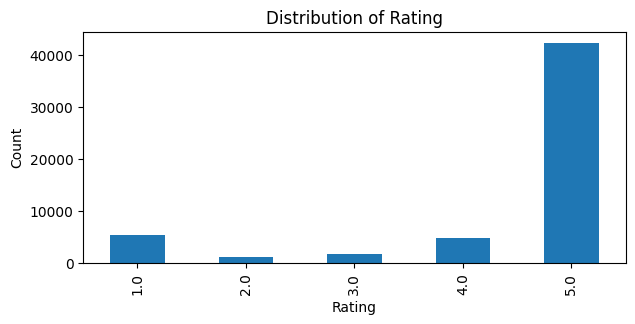

In [120]:
# Plot distribution of rating
plt.figure(figsize=(7,3))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 10 Highest-Reviewed Processors')

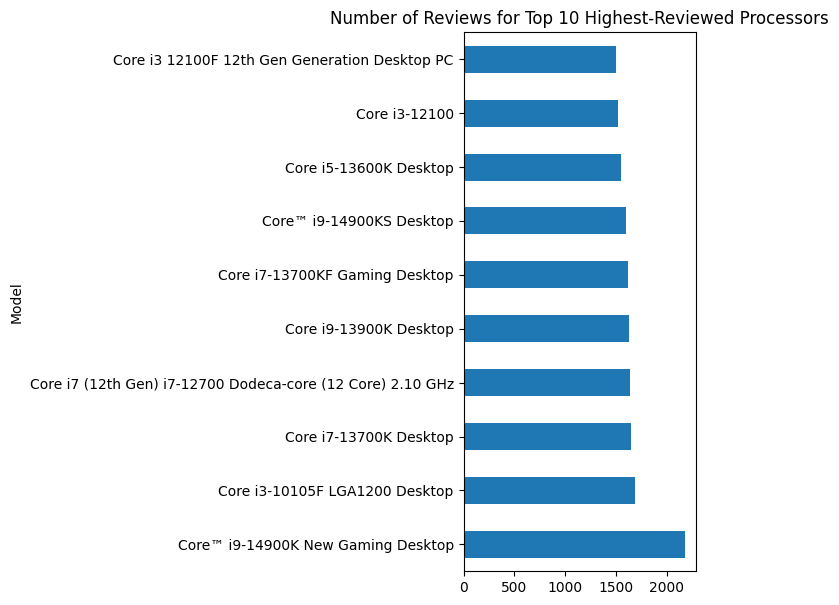

In [121]:
# Plot number of reviews for top 10
brands = df["Model"].value_counts()
# brands.count()
plt.figure(figsize=(3,7))
brands[:10].plot(kind='barh')

plt.title("Number of Reviews for Top 10 Highest-Reviewed Processors")

Text(0, 0.5, 'Count')

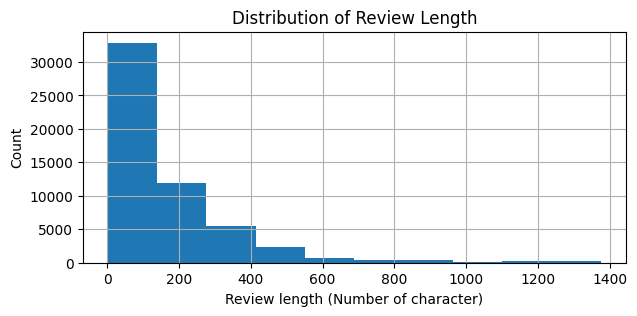

In [122]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(7,3))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

2024-07-05 10:57:24,402 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-05 10:57:24,468 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


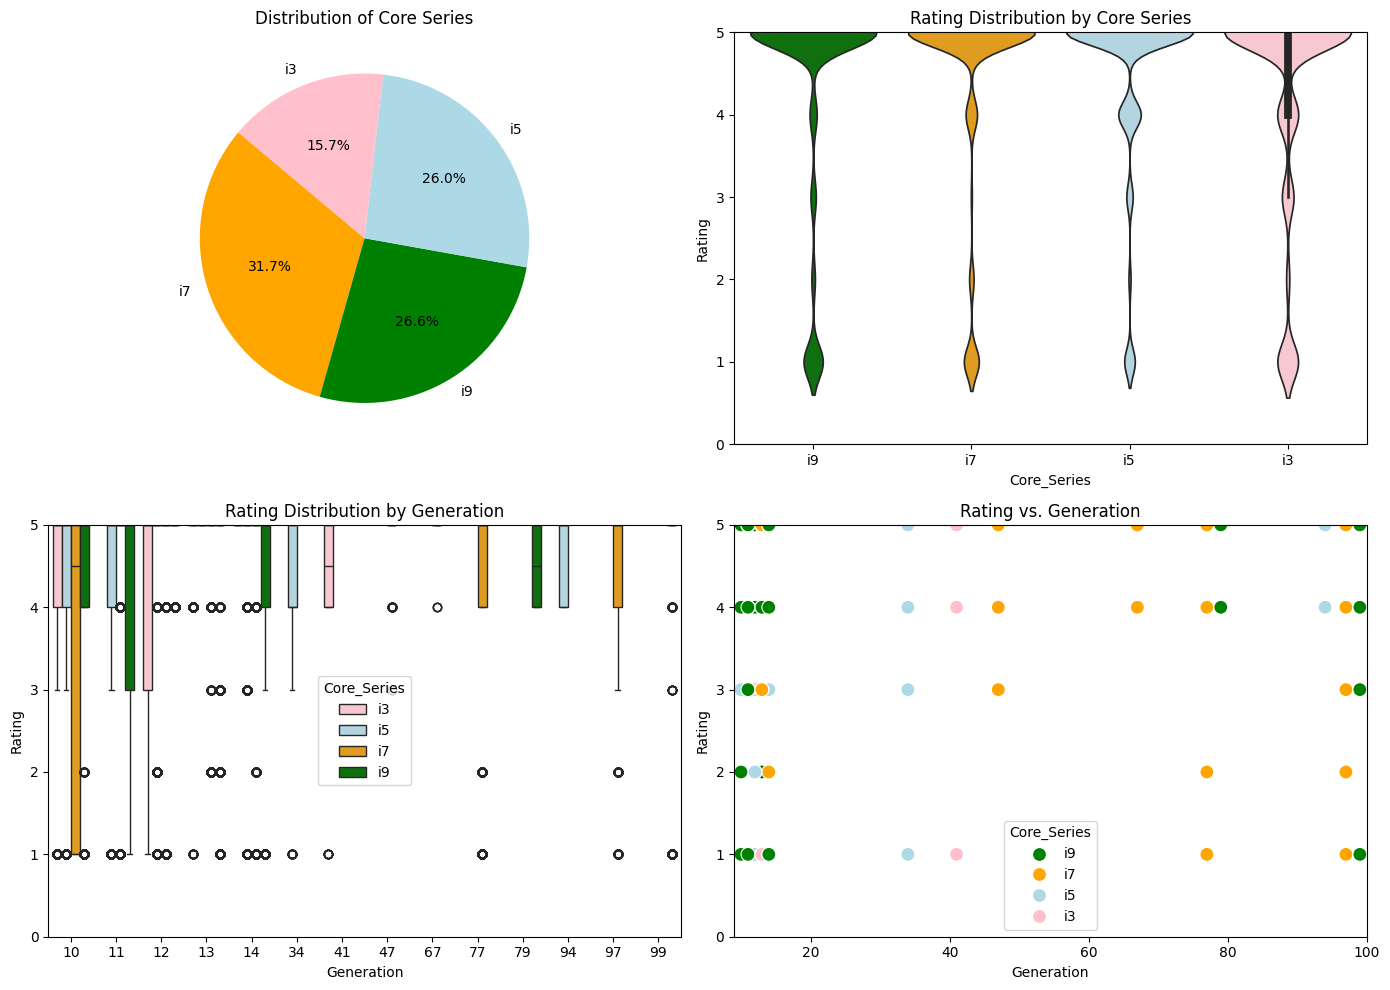

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Define custom color dictionary for Core Series
core_series_colors = {'i3': 'pink', 'i5': 'lightblue', 'i7': 'orange', 'i9': 'green'}

# Plot 1: Pie chart of Core Series distribution
core_series_counts = df['Core_Series'].value_counts()
axs[0, 0].pie(core_series_counts, labels=core_series_counts.index, autopct='%1.1f%%', startangle=140, colors=[core_series_colors[x] for x in core_series_counts.index])
axs[0, 0].set_title('Distribution of Core Series')

# Plot 2: Violin plot of Ratings by Core Series
sns.violinplot(data=df, x='Core_Series', y='Rating', hue='Core_Series', palette=core_series_colors, ax=axs[0, 1])
axs[0, 1].set_title('Rating Distribution by Core Series')
axs[0, 1].set_ylim(0, 5)

# Plot 3: Box plot of Ratings by Generation
sns.boxplot(data=df, x='Generation', y='Rating', hue='Core_Series', palette=core_series_colors, ax=axs[1, 0])
axs[1, 0].set_title('Rating Distribution by Generation')
axs[1, 0].set_ylim(0, 5)

# Plot 4: Scatter plot of Rating vs. Generation
sns.scatterplot(data=df, x='Generation', y='Rating', hue='Core_Series', palette=core_series_colors, s=100, ax=axs[1, 1])
axs[1, 1].set_title('Rating vs. Generation')
axs[1, 1].set_ylim(0, 5)
axs[1, 1].set_xlim(df['Generation'].min() - 1, df['Generation'].max() + 1)

plt.tight_layout()
plt.show()



---
<a id="part2"></a>
## Part 2. Data Preparation

For illustrative purpose, I use only 10% of the data in this project. To simply the problem, I only consider reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2), and drop reviews with neutral sentiment (rating 3). 


### Prepare Data

In [124]:
df = df.sample(frac=1, random_state=71) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

#Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head(40)

,Brand,Core_Series,Generation,Model,Rating,Date,Location,Reviews,Sentiment
42044,Intel,i3,10,Core i3-10100,1.0,21 November 2020,India,Processor box was already open. But thank God ...,0
11401,Intel,i7,13,Core i7-13700K Desktop,5.0,24 July 2023,Canada,This processor performs well and is a solid pe...,1
43910,Intel,i7,13,Core i7-13700KF Gaming Desktop,4.0,17 June 2023,France,Pas de problème pour moi....,1
3247,Intel,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,2 January 2024,the United States,I got this CPU because I've been a long term I...,1
8671,Intel,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,24 April 2024,Germany,The seller posted the item but there was a del...,1
52039,Intel,i3,10,Core i3-10100F 10th Generation LGA1200 Desktop,5.0,3 October 2023,India,Kerala Kozhikode,1
2322,Intel,i7,13,Core i7-13700K Desktop,5.0,24 April 2024,Spain,Muy buena marca,1
51799,Intel,i7,47,Core i7-4790K Unlocked 4.0 GHz Quad Core LGA11...,5.0,10 September 2016,India,Processor is so fast.Best for gamming & Video ...,1
38256,Intel,i3,12,Core i3 12100F 12th Gen Generation Desktop PC,5.0,27 January 2024,Brazil,"Muito bom, super recomendo",1
7197,Intel,i9,13,Core™ i9-13900F,1.0,6 March 2024,Italy,Davvero deluso!,0


In [125]:
def is_english(text):
  """Checks if the text is in English using langdetect"""
  try:
    return langdetect.detect(text) == 'en'
  except langdetect.LangDetectException:  # Handle potential errors
    return False

# Drop rows with missing reviews or non-English reviews
df = df[df['Reviews'].notnull() & df['Reviews'].apply(is_english)]

df.head(5)

,Brand,Core_Series,Generation,Model,Rating,Date,Location,Reviews,Sentiment
42044,Intel,i3,10,Core i3-10100,1.0,21 November 2020,India,Processor box was already open. But thank God ...,0
11401,Intel,i7,13,Core i7-13700K Desktop,5.0,24 July 2023,Canada,This processor performs well and is a solid pe...,1
3247,Intel,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,2 January 2024,the United States,I got this CPU because I've been a long term I...,1
8671,Intel,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,24 April 2024,Germany,The seller posted the item but there was a del...,1
51799,Intel,i7,47,Core i7-4790K Unlocked 4.0 GHz Quad Core LGA11...,5.0,10 September 2016,India,Processor is so fast.Best for gamming & Video ...,1


In [126]:
df.shape

(32099, 9)

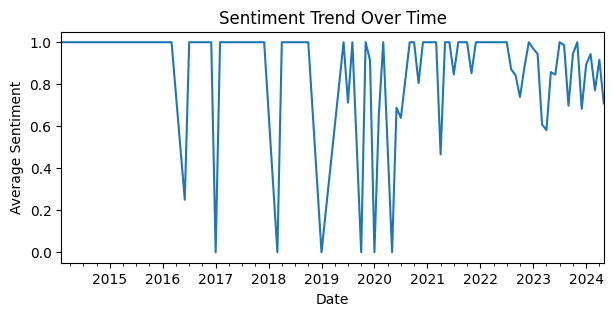

In [127]:
df['Date'] = pd.to_datetime(df['Date'], format='%d %B %Y')

# Plot sentiment trends over time
plt.figure(figsize=(7, 3))
df.groupby(df['Date'].dt.to_period('M'))['Sentiment'].mean().plot(kind='line')
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()

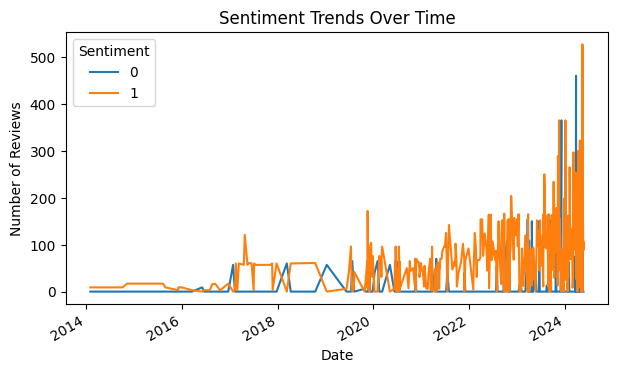

In [128]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group data by date and sentiment, count occurrences, and unstack the result
sentiment_trend = df.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trends over time
sentiment_trend.plot(kind='line', figsize=(7, 4))

# Add title and labels
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')

# Show plot
plt.show()


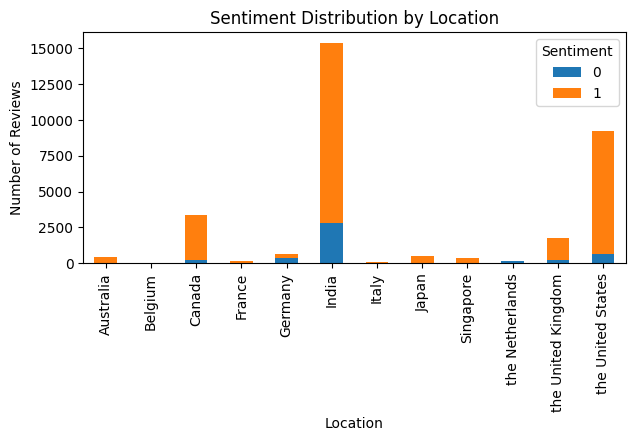

In [129]:
location_sentiment_count = df.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment counts for each location
location_sentiment_count.plot(kind='bar', stacked=True, figsize=(7, 3))

# Add title and labels
plt.title('Sentiment Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Number of Reviews')

# Show legend
plt.legend(title='Sentiment')

# Show plot
plt.show()

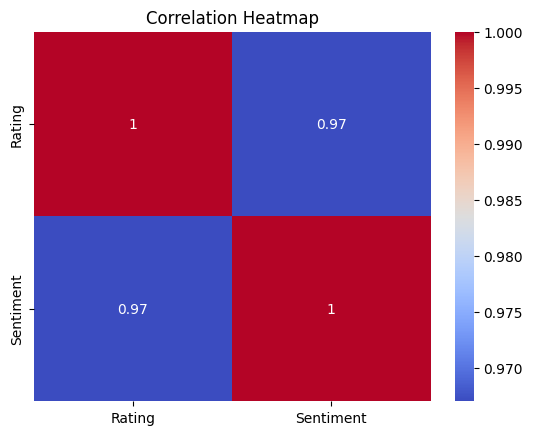

In [130]:
import seaborn as sns

# Select columns for the heatmap
columns = ['Rating', 'Sentiment']

# Compute the correlation matrix
correlation_matrix = df[columns].corr()

# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [131]:
# Now we remove Brand column as it is redundant
df.drop(columns=['Brand'], inplace=True)
df

,Core_Series,Generation,Model,Rating,Date,Location,Reviews,Sentiment
42044,i3,10,Core i3-10100,1.0,2020-11-21,India,Processor box was already open. But thank God ...,0
11401,i7,13,Core i7-13700K Desktop,5.0,2023-07-24,Canada,This processor performs well and is a solid pe...,1
3247,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,2024-01-02,the United States,I got this CPU because I've been a long term I...,1
8671,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,2024-04-24,Germany,The seller posted the item but there was a del...,1
51799,i7,47,Core i7-4790K Unlocked 4.0 GHz Quad Core LGA11...,5.0,2016-09-10,India,Processor is so fast.Best for gamming & Video ...,1
...,...,...,...,...,...,...,...,...
38945,i3,10,Core i3-10105F LGA1200 Desktop,5.0,2024-04-27,the United Kingdom,Really good and can basically run any game I t...,1
50086,i3,10,Core i3-10100F 10th Generation LGA1200 Desktop,4.0,2021-07-10,India,If you are buying this processor you need to h...,1
47866,i7,77,Core™ i7-7700,5.0,2017-11-07,India,First of all thanks to the B Online Store for ...,1
35553,i9,14,Core™ i9-14900K New Gaming Desktop,1.0,2024-03-28,India,I don't liked the price of it .,0


### Train Test Split 

In [132]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(df["Reviews"], df["Sentiment"],
                                                   test_size=0.35, random_state=50)

print('Loaded %d training examples and %d validation examples.\n' % (X_train.shape[0], X_test.shape[0]))

# Print a sample review from the training set
print('Sample review in the training set:\n', X_train.iloc[0])  # Use iloc to access by positional index

# Example of iterating through first few reviews in training set
print('\nFirst few reviews in the training set:')
for i in range(5):
    print(f'Review {i+1}: {X_train.iloc[i]}')

Loaded 20864 training examples and 11235 validation examples.

Sample review in the training set:
 Ultimate Performance

First few reviews in the training set:
Review 1: Ultimate Performance
Review 2: Those who are looking for budget processor for 'basic use' , they can go for it. This processor is perfect for them.  simply don't waste your money on high end processor , which may not required for your work.
Review 3: The Intel Core i9 13900K is an absolute powerhouse! Its blazing speeds and unrivaled performance have transformed my computing experience. Multitasking is a breeze, and demanding applications run seamlessly. The advanced technology and impressive efficiency make it a must-have for any tech enthusiast. Truly a 5-star gem!
Review 4: 13 gen is better with same performence at low pricing. Avoid this product cause it have only 2 core touching 6000 mhz so in real life there are no difference.
Review 5: I am not a gamer. I just bought for my software purpose like MATLAB & Python 

In [133]:

# Load your data (df["Reviews"] and df["Sentiment"])

# Define the undersampling method (RandomUnderSampler)
rus = RandomUnderSampler(random_state=50)

# Undersample while preserving data types (using Series.to_frame)
X_resampled_df = pd.DataFrame(df["Reviews"].values.reshape(-1, 1), columns=["Reviews"])
y_resampled_df = pd.Series(df["Sentiment"])
X_resampled, y_resampled = rus.fit_resample(X_resampled_df, y_resampled_df)

# Convert back to pandas Series after undersampling (assuming text in "Reviews")
X_resampled = pd.Series(X_resampled.squeeze())  # Assuming text data in first column

# Split the undersampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.35, random_state=50)

# Print class distribution after undersampling
print('Class distribution after undersampling:')
print(y_train.value_counts())  # Print counts for each sentiment class

print('Loaded %d training examples and %d validation examples.\n' % (X_train.shape[0], X_test.shape[0]))

Class distribution after undersampling:
Sentiment
0    2943
1    2914
Name: count, dtype: int64
Loaded 5857 training examples and 3155 validation examples.



---
<a id="part3"></a>
## Part 3. Bag of Words

The goal of this project is to classify the reviews into positive and negative sentiment. There are two main steps involved. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

* Step 1 : Preprocess raw reviews to cleaned reviews
* Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
* Step 3 : Transform review text to numerical representations (feature vectors)
* Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
* Step 5 : Improve the model performance by GridSearch

### Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [134]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [135]:
from bs4 import BeautifulSoup
import numpy as np

# Assuming X_train and X_test are lists of text data
# Define a function to clean text data

# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n')
for i in range(5):
    print(X_train_cleaned[i])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

C:\Users\garvb\AppData\Local\Temp\ipykernel_10792\179031280.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


Show a cleaned review in the training set : 

cpu stock cooler fan got broken with blade in box was creating noise and virbration in cpu but processor was working fine so thought to replace but if replace it i dont know what i am gonna get with broken cpu chip so i replaced stock cooler with deepcool air cooler now it s working fine please don t buy critical pc parts from amazon you may end up getting with broken parts worst packing
a friend told me he was running tekken on a th gen i so that was enough for me to switch my plans over to intel
the pc works fine but while working out with this pc at ghz it stutters a lot and u come do multi tasking i would prefare u to run the cpu at max ghz cause if u go beyond that there will be heating issues in normal use as well my cpu at ghz went from c to c although cpu fan running at and fan also makes a lot of noise this will shorten the life expectancy of the pc a lot
you can clearly see this product which was purchased new was actually used wi

### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm. 

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" % len(countVect.get_feature_names_out())) #6378 
print("Show some feature names : \n", countVect.get_feature_names_out()[1::1000])

# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)


Number of features : 2115 

Show some feature names : 
 ['ability' 'limited' 'vmware']


MultinomialNB()

In [137]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [138]:
# Evaluate the model on validaton set
X_test_features = countVect.transform(X_test_cleaned) 
predictions = mnb.predict(X_test_features)
modelEvaluation(predictions)


Accuracy on validation set: 0.9794

AUC score : 0.9796

Classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1563
           1       1.00      0.96      0.98      1592

    accuracy                           0.98      3155
   macro avg       0.98      0.98      0.98      3155
weighted avg       0.98      0.98      0.98      3155


Confusion Matrix : 
 [[1560    3]
 [  62 1530]]


### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus. 

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [139]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out())) #1722
print("Show some feature names : \n", tfidf.get_feature_names_out()[1::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 2183 

Show some feature names : 
 ['0ghz' 'hefty' 'trouble']


LogisticRegression()

In [140]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['broken' 'overheating' 'ryzen' 'received' 'was' 'it' 'different' 'box'
 'apart' 'worst']

Top 10 features with largest coefficients : 
['for' 'great' 'good' 'my' 'which' 'fast' 'best' 'need' 'have' 'i5']


In [141]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9984

AUC score : 0.9984

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1563
           1       1.00      1.00      1.00      1592

    accuracy                           1.00      3155
   macro avg       1.00      1.00      1.00      3155
weighted avg       1.00      1.00      1.00      3155


Confusion Matrix : 
 [[1560    3]
 [   2 1590]]


### Pipeline and GridSearch

In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [142]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.35, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 64], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': 1000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}

Accuracy on validation set: 0.9997

AUC score : 0.9997

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1563
           1       1.00      1.00      1.00      1592

    accuracy                           1.00      3155
   macro avg       1.00      1.00      1.00      3155
weighted avg       1.00      1.00      1.00      3155


Confusion Matrix : 
 [[1563    0]
 [   1 1591]]


---
<a id="part4"></a>
## Part 4. Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Step 2 : Create volcabulary list using Word2Vec model
* Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
* Step 4 : Fit the average feature vectors to Random Forest Classifier

### Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [143]:
from nltk.tokenize import word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer
import nltk
nltk.download('punkt')

# Define the tokenizer
tokenizer = PunktSentenceTokenizer()

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(word_tokenize(cleanText(raw_sentence, remove_stopwords)))
    return sentences

# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)

print('%d parsed sentences in the training set\n' % len(sentences))
print("Some parsed sentences from the training set:")
for i in range(5):  # Adjust the range as needed
    print(f"Sentence {i+1}: {sentences[i]}")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garvb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


5857 parsed sentences in the training set

Some parsed sentences from the training set:
Sentence 1: ['cpu', 'stock', 'cooler', 'fan', 'got', 'broken', 'with', 'blade', 'in', 'box', 'was', 'creating', 'noise', 'and', 'virbration', 'in', 'cpu', 'but', 'processor', 'was', 'working', 'fine', 'so', 'thought', 'to', 'replace', 'but', 'if', 'replace', 'it', 'i', 'dont', 'know', 'what', 'i', 'am', 'gon', 'na', 'get', 'with', 'broken', 'cpu', 'chip', 'so', 'i', 'replaced', 'stock', 'cooler', 'with', 'deepcool', 'air', 'cooler', 'now', 'it', 's', 'working', 'fine', 'please', 'don', 't', 'buy', 'critical', 'pc', 'parts', 'from', 'amazon', 'you', 'may', 'end', 'up', 'getting', 'with', 'broken', 'parts', 'worst', 'packing']
Sentence 2: ['a', 'friend', 'told', 'me', 'he', 'was', 'running', 'tekken', 'on', 'a', 'th', 'gen', 'i', 'so', 'that', 'was', 'enough', 'for', 'me', 'to', 'switch', 'my', 'plans', 'over', 'to', 'intel']
Sentence 3: ['the', 'pc', 'works', 'fine', 'but', 'while', 'working', 'out',

### Creating Volcabulary List using Word2Vec Model

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word vector representations by sepcifiying the embedding dimension (= length of feature vector).

In [144]:
import logging
import re
from gensim.models import Word2Vec

# Enable logging for gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300  # Embedding dimension
min_word_count = 10  # Minimum word count
num_workers = 4  # Number of threads to run in parallel
context = 10  # Context window size
downsampling = 1e-3  # Downsample setting for frequent words
epochs = 3  # Number of epochs

print("Training Word2Vec model ...\n")

# Assume `sentences` is your list of tokenized sentences
w2v = Word2Vec(sentences=sentences,vector_size=num_features, min_count=min_word_count, workers=num_workers,
               window=context, sample=downsampling)

w2v.build_vocab(sentences)

# Train the model
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=epochs)

# To make the model memory-efficient
w2v.init_sims(replace=True)

# Save the model
w2v.save("w2v_300features_10minwordcounts_10context")

# Access vocabulary information (avoiding deprecated 'vocab' attribute)
all_words = list(w2v.wv.key_to_index.keys())  # Get all words using key_to_index

# Remove punctuation and other symbols
cleaned_vocabulary = [word for word in all_words if re.match(r'^\w+$', word)]

print("Number of words in the cleaned vocabulary list: %d \n" % len(cleaned_vocabulary))
print("Show words in the cleaned vocabulary list: \n", cleaned_vocabulary)


2024-07-05 11:02:16,352 : INFO : collecting all words and their counts
2024-07-05 11:02:16,353 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-07-05 11:02:16,380 : INFO : collected 2135 word types from a corpus of 203287 raw words and 5857 sentences
2024-07-05 11:02:16,381 : INFO : Creating a fresh vocabulary
2024-07-05 11:02:16,387 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 1539 unique words (72.08% of original 2135, drops 596)', 'datetime': '2024-07-05T11:02:16.387696', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2024-07-05 11:02:16,388 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 200192 word corpus (98.48% of original 203287, drops 3095)', 'datetime': '2024-07-05T11:02:16.388688', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, In

Training Word2Vec model ...



2024-07-05 11:02:16,650 : INFO : EPOCH 1: training on 203287 raw words (144451 effective words) took 0.1s, 1328400 effective words/s
2024-07-05 11:02:16,779 : INFO : EPOCH 2: training on 203287 raw words (144608 effective words) took 0.1s, 1181065 effective words/s
2024-07-05 11:02:16,907 : INFO : EPOCH 3: training on 203287 raw words (144588 effective words) took 0.1s, 1219655 effective words/s
2024-07-05 11:02:17,029 : INFO : EPOCH 4: training on 203287 raw words (144670 effective words) took 0.1s, 1269094 effective words/s
2024-07-05 11:02:17,030 : INFO : Word2Vec lifecycle event {'msg': 'training on 1016435 raw words (722599 effective words) took 0.6s, 1173109 effective words/s', 'datetime': '2024-07-05T11:02:17.030171', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'train'}
2024-07-05 11:02:17,031 : INFO : Word2Vec lifecycle event {'params': 'Word2Ve

Number of words in the cleaned vocabulary list: 1539 

Show words in the cleaned vocabulary list: 
 ['i', 'the', 'it', 'and', 'a', 'this', 'to', 'with', 'is', 'was', 'for', 'cpu', 'in', 'of', 'processor', 'but', 't', 'not', 'so', 's', 'on', 'my', 'that', 'you', 'good', 'at', 'no', 'from', 'intel', 'as', 'have', 'if', 'price', 'gen', 'can', 'are', 'product', 'cooler', 'k', 'fine', 'had', 'box', 'core', 'get', 'performance', 'gaming', 'better', 'stock', 'don', 'be', 'very', 'will', 'amazon', 'than', 'works', 'one', 'or', 'graphics', 'only', 'an', 'broken', 'working', 'up', 'fan', 'more', 'even', 'm', 'run', 'any', 'got', 'there', 'like', 'buy', 'low', 'th', 'just', 'what', 'pc', 'used', 'when', 'would', 'great', 'time', 'while', 'card', 'all', 'work', 'motherboard', 'bought', 'cores', 'ryzen', 'after', 'new', 'same', 'am', 'games', 'power', 'chip', 'they', 'return', 'well', 'upgrade', 'me', 'money', 'didn', 'f', 'mhz', 'its', 'computer', 'trying', 'now', 'difference', 'use', 'fast', 'set

### Averaging Feature Vectors

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review. 

In [145]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
  """
  Transforms a review into a feature vector by averaging word vectors.

  Args:
      review (list): List of words in the review.
      model (gensim.models.Word2Vec): The trained Word2Vec model.
      num_features (int): Dimensionality of the word vectors.

  Returns:
      numpy.ndarray: Feature vector representing the review (shape: (num_features,)).
  """

  feature_vec = np.zeros((num_features,), dtype="float32")
  word_count = 0

  # Iterate through words in the review, checking for existence and adding vectors
  for word in review:
    if word in model.wv.key_to_index:  # Check if word exists in vocabulary
      word_count += 1
      feature_vec = np.add(feature_vec, model.wv[word])  # Use model.wv for word vectors

  # Handle cases with no words in vocabulary (return zero vector)
  if word_count == 0:
    return feature_vec

  # Average the feature vector (divide by word count)
  return np.divide(feature_vec, word_count)


def getAvgFeatureVecs(reviews, model, num_features):
  """
  Transforms all reviews in a list into feature vectors using makeFeatureVec.

  Args:
      reviews (list): List of reviews (each review is a list of words).
      model (gensim.models.Word2Vec): The trained Word2Vec model.
      num_features (int): Dimensionality of the word vectors.

  Returns:
      numpy.ndarray: Feature vectors for all reviews (shape: (len(reviews), num_features)).
  """

  review_feature_vecs = np.zeros((len(reviews), num_features), dtype="float32")
  for i, review in enumerate(reviews):
    review_feature_vecs[i] = makeFeatureVec(review, model, num_features)

  return review_feature_vecs

In [146]:
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" % trainVector.shape)

# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" % testVector.shape)

C:\Users\garvb\AppData\Local\Temp\ipykernel_10792\179031280.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


Training set : 5857 feature vectors with 300 dimensions
Validation set : 3155 feature vectors with 300 dimensions


### Random Forest Classifer

We can now train Random Forest Classifier using feature vectors of reviews in the training set. 

In [147]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=50, max_depth=7)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.9997

AUC score : 0.9997

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1563
           1       1.00      1.00      1.00      1592

    accuracy                           1.00      3155
   macro avg       1.00      1.00      1.00      3155
weighted avg       1.00      1.00      1.00      3155


Confusion Matrix : 
 [[1563    0]
 [   1 1591]]


In [148]:
# Feature importance based on RandomForestClassifier
feature_importance = rf.feature_importances_

# Get feature names (assuming df is a pandas DataFrame)
feature_names = df.columns

# Sort feature importance in descending order
sorted_idx = np.argsort(feature_importance)[::-1]

# Print feature importance ranking
print("Feature importance ranking:")
for i in sorted_idx:
    if i < len(feature_names):  # Ensure index is within bounds
        print(f"{feature_names[i]}: {feature_importance[i]}")

Feature importance ranking:
Core_Series: 0.005319836431904673
Reviews: 0.003272750359289569
Model: 0.002704972980073517
Rating: 0.001751794911108405
Date: 0.0015619599270057535
Location: 0.0008367143256743543
Sentiment: 0.0006667887741928002
Generation: 0.0003558723018126096


---
<a id="part5"></a>
## Part 5. LSTM



Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative  sentiment using Keras libarary.

### Simple LSTM

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.
* Step 1 : Prepare X_train and X_test to 2D tensor
* Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [256]:
top_words = 10000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train_cleaned)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (5857, 100)
X_test shape: (3155, 100)
y_train shape: (5857, 2)
y_test shape: (3155, 2)


In [257]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 64,activity_regularizer=regularizers.L2(1e-5)))
model1.add(Dropout(0.4))
model1.add(LSTM(64))
model1.add(Dropout(0.55))
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evaluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.7074 - loss: 0.5855
Epoch 2/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9884 - loss: 0.0548
Epoch 3/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9972 - loss: 0.0149
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9985 - loss: 0.0175
Test loss : 0.0174
Test accuracy : 0.9984


In [258]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[4].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (10000, 64)
Size of weight matrix in the hidden layer :  (64, 256)
Size of weight matrix in the output layer :  (64, 2)


### LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account.  The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to 
intialize the weights of embedding layer in LSTM.

* Step 1 : Load pretrained word embedding model
* Step 2 : Construct embedding layer using embedding matrix as weights
* Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [189]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

2024-07-05 11:23:05,009 : INFO : loading Word2Vec object from w2v_300features_10minwordcounts_10context
2024-07-05 11:23:05,018 : INFO : loading wv recursively from w2v_300features_10minwordcounts_10context.wv.* with mmap=None
2024-07-05 11:23:05,020 : INFO : setting ignored attribute cum_table to None
2024-07-05 11:23:05,031 : INFO : Word2Vec lifecycle event {'fname': 'w2v_300features_10minwordcounts_10context', 'datetime': '2024-07-05T11:23:05.031802', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'loaded'}


Shape of embedding matrix :  (1539, 300)


In [262]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train_cleaned)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train_cleaned shape:', X_train_seq.shape) #(27799, 100)
print('X_test_cleaned shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train_cleaned shape: (5857, 100)
X_test_cleaned shape: (3155, 100)
y_train shape: (5857, 2)
y_test shape: (3155, 2)


In [263]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix],
                           activity_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-6))


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Dropout(0.4))
model2.add(LSTM(128))
model2.add(Dropout(0.55))
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)        │ ?                      │       461,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,700 (1.76 MB)

 Trainable params: 461,700 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.8039 - loss: 0.5358
Epoch 2/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9976 - loss: 0.0786
Epoch 3/3
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9992 - loss: 0.0553
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9984 - loss: 0.0572
Test loss : 0.0568
Test accuracy : 0.9990


In [264]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[4].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (1539, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


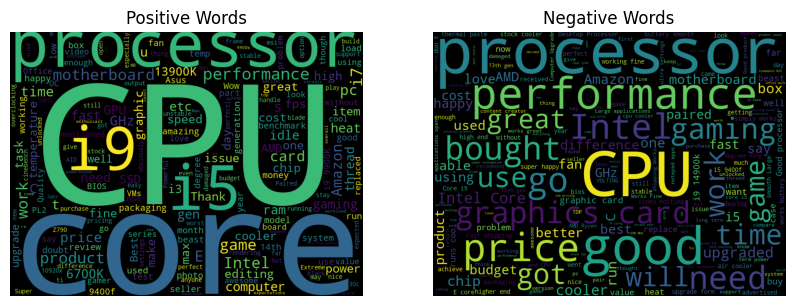

In [57]:
predictions = model2.predict(X_test_seq)  # Get probabilities for each sentiment class
predictions = np.argmax(predictions, axis=-1) 
# Initialize empty lists for positive and negative words
positive_words = []
negative_words = []

# Loop through reviews, predictions, and pre-trained embeddings (assuming you have them)
for review, sentiment, embedding in zip(df["Reviews"], predictions, X_test_seq):
  words = review.split()  # Split review into words
  embedding_list = embedding.tolist()  # Assuming embedding is a numpy array

  # Filter words based on predicted sentiment and embedding existence
  for word, word_embedding in zip(words, embedding_list):
    if word_embedding is not None:  # Check if embedding exists (optional)
      if sentiment == 1:  # Positive sentiment
        if word not in positive_words:  # Add unique words to list
          positive_words.append(word)
      else:  # Negative sentiment
        negative_words.append(word)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=600).generate(" ".join(positive_words))
negative_wordcloud = WordCloud(width=800, height=600).generate(" ".join(negative_words))

# Display or save word clouds
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(positive_wordcloud)
plt.title('Positive Words')
plt.axis("off")

plt.subplot(122)
plt.imshow(negative_wordcloud)
plt.title('Negative Words')
plt.axis("off")

plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garvb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\garvb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


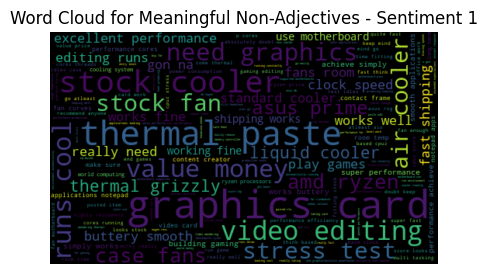

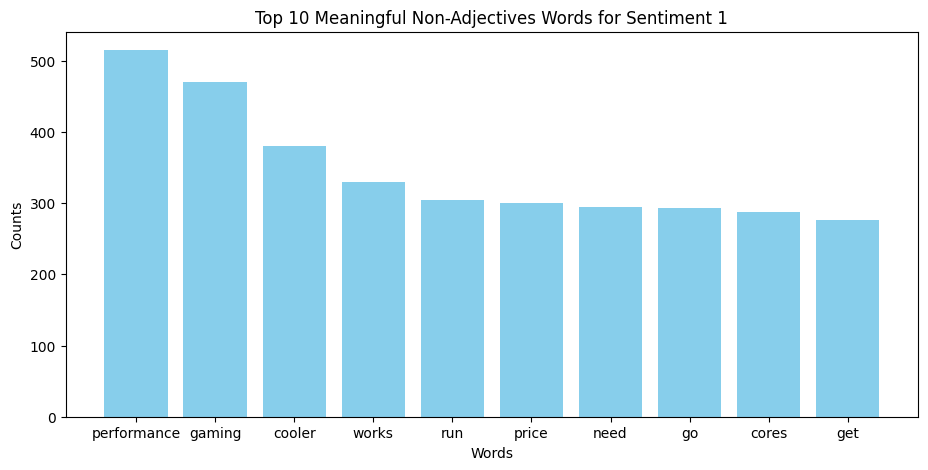

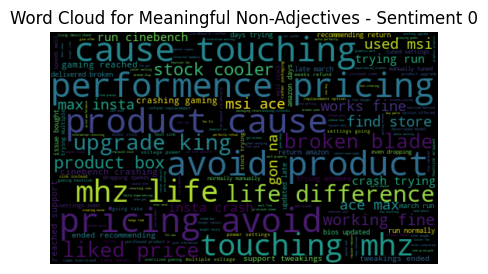

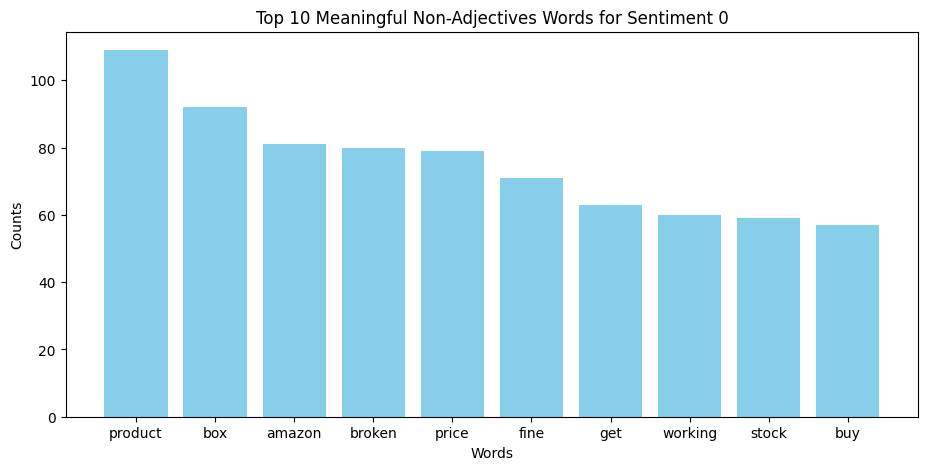

In [58]:
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK stopwords and part-of-speech tagger
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def is_adjective(word):
    """Check if a word is an adjective."""
    return pos_tag([word])[0][1] == 'JJ'

def is_meaningful(word):
    """Check if a word is a meaningful non-adjective."""
    pos_tagged = pos_tag([word])[0][1]
    # Include only nouns, verbs, and adverbs
    return pos_tagged.startswith('N') or pos_tagged.startswith('V') or pos_tagged == 'RB'

# Extend stopwords with common non-characteristic words
additional_stopwords = {'cpu', 'processor', 'monitor', 'pc', 'computer', 'intel', 'core', 'generation', 'desktop', 'gen', 'i5', 'i7', 'i9', 'pentium'}
stop_words = set(stopwords.words('english')).union(additional_stopwords)

def create_word_cloud_with_top_words(sentiment, adjectives_only=True):
    df_sample = df[df['Sentiment'] == sentiment]
    df_sample = df_sample.sample(frac=0.1, random_state=0)
    
    word_cloud_collection = ''
    
    for val in df_sample['Reviews'].str.lower():
        tokens = nltk.word_tokenize(val)
        if adjectives_only:
            tokens = [word for word in tokens if word.isalpha() and word not in stop_words and is_adjective(word)]
        else:
            tokens = [word for word in tokens if word.isalpha() and word not in stop_words and is_meaningful(word)]
        word_cloud_collection += ' '.join(tokens) + ' '
    
    wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    sentiment_type = 'Adjectives' if adjectives_only else 'Meaningful Non-Adjectives'
    plt.title(f'Word Cloud for {sentiment_type} - Sentiment {sentiment}')
    plt.show()
    
    # Plot top 5 words
    word_counts = Counter(word_cloud_collection.split())
    top_words = word_counts.most_common(10)
    
    words, counts = zip(*top_words)
    plt.figure(figsize=(11, 5))
    plt.bar(words, counts, color='skyblue')
    plt.title(f'Top 10 {sentiment_type} Words for Sentiment {sentiment}')
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

# Create word clouds and top words for positive (1) and negative (0) sentiments
# For Meaningful Non-Adjectives
create_word_cloud_with_top_words(1, adjectives_only=False)
create_word_cloud_with_top_words(0, adjectives_only=False)


---
<a id="part7"></a>
## Part 7. Summary Generation

In [59]:
from transformers import pipeline

In [60]:
# Initialize the BERT summarization pipeline with the specific model
summarizer = pipeline("summarization", model="google/flan-t5-base")

2024-07-05 10:42:32,891 : WARNING : From C:\Users\garvb\anaconda3\envs\Devshouse\lib\site-packages\tf_keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



Using BERT: BERT (Bidirectional Encoder Representations from Transformers) is a powerful language model that can be used for text summarization. BERT-based models have achieved state-of-the-art results in various natural language processing tasks, including text summarization.

In [61]:

# Get positive texts from the 'text' column in your dataset
positive_texts =  df[df['Sentiment'] == 1]['Reviews'].tolist()


# Combine all positive texts into one string
combined_text = " ".join(positive_texts)

# Split the combined text into chunks of maximum length 1024
texts = []
chunk = ""
for sentence in combined_text.split():
    if len(chunk) + len(sentence) > 1024:
        texts.append(chunk)
        chunk = ""
    chunk += sentence + " "
if chunk:
    texts.append(chunk)
summaries = []
# Generate summaries for each chunk of text
for i, text in enumerate(texts):
    if i >= 10:
        break
    print("\nSummary:")
    summary = summarizer(text, max_length=100, min_length=30, do_sample=False)
    print(summary[0]['summary_text'])
    summaries.append(summary[0]['summary_text']) 




Summary:
I've been a long term Intel user and I have never had problems with them. This one replaced my i7-6700K and it is noticeably faster for my daily work (mostly Office, Internet content) and gaming (COD MW3). In terms of power consumption and heat generation, I can hardly notice it since all the workload I put on it hardly heats it up more than 45C-50C.

Summary:
Great product, but overpriced. It shouldn't be above 37K. It's worth for money. However, every motherboard manufacturer is now OVER VOLTING the CPUs causing them to run hotter and be less efficient so they can pass benchmarks with slightly higher scores at the cost of cooking your CPU. Now that the 10th gen is out, this is an obsolete review.

Summary:
RTX 2080 in 4K. Works well, 36 cores are going to be useful to run several VMs. Single thread it's not much faster

Summary:
This processor works like new! Don't know if it was used or not but it came in a clamshell with fairly factory looking stuff on it

Summary:
I am r

In [62]:
# Combine individual summaries into a single string
combined_summaries = " ".join(summaries)

# Summarize the combined summaries
final_summary = summarizer(combined_summaries, max_length=200, min_length=50, do_sample=False)
print("\nFinal Summary:")
print(final_summary[0]['summary_text'])

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors



Final Summary:
I've been a long term Intel user and I have never had problems with them. This one replaced my i7-6700K and it is noticeably faster for my daily work (mostly Office, Internet content) and gaming (COD MW3). In terms of power consumption and heat generation, I can hardly notice it since all the workload I put on it ...


In [63]:

# Get positive texts from the 'text' column in your dataset
negative_texts = positive_texts = df[df['Sentiment'] == 0]['Reviews'].tolist()


# Combine all positive texts into one string
combined_text = " ".join(negative_texts)

# Split the combined text into chunks of maximum length 1024
texts = []
chunk = ""
for sentence in combined_text.split():
    if len(chunk) + len(sentence) > 1024:
        texts.append(chunk)
        chunk = ""
    chunk += sentence + " "
if chunk:
    texts.append(chunk)
summaries = []
# Generate summaries for each chunk of text
for i, text in enumerate(texts):
    if i >= 10:
        break
    print("\nSummary:")
    summary = summarizer(text, max_length=100, min_length=30, do_sample=False)
    print(summary[0]['summary_text'])
    summaries.append(summary[0]['summary_text']) 




Summary:
Product was installed in the computer. After working for 7-10 days it has stopped working. Now I am unable to get any information where should I approach.

Summary:
Used it on a Z790 msi ace max, it was very unstable, insta crash while trying to run cinebench r23, crashing while gaming, I reached intel support and after some tweakings they ended up recommending to return it to Amazon as it was less than 30 days I had the cpu, I'm not trying this one anymore

Summary:
Computer. After working for 7-10 days it has stopped working. Now I am unable to get any information where should I approach. I contacted supplier he say talk to Amazon

Summary:
This seems like a good CPU so far but it was packaged very poorly - the chip was literally rattling around loose inside the Amazon box.

Summary:
it was very unstable, insta crash while trying to run cinebench r23, crashing while gaming, I reached intel support and after ...

Summary:
I reached intel support and after some tweakings they

In [64]:
# Combine individual summaries into a single string
combined_summaries = " ".join(summaries)

# Summarize the combined summaries
final_summary = summarizer(combined_summaries, max_length=200, min_length=50, do_sample=False)
print("\nFinal Summary:")
print(final_summary[0]['summary_text'])


Final Summary:
DO NOT BUY THIS PRODUCT. DO NOT buy critical PC parts from Amazon you may end up getting with broken parts worst packing Overheating followed all instructions was very careful with everything and now i can't play for more than an hour without PC crashing Was not shipped from Canada, shipped from the US, didn't come


---
<a id="part8"></a>
## Part 8. Predictions

In [265]:
test =["Fantastic Product, Loved it", "Worst product in series", "Could have been better", "Heating issues and delivered late"]
cleaned_test = [cleanText(review) for review in test]
tokenizer = Tokenizer(num_words=top_words)  # Consider using 'num_words' instead of 'nb_words'
print(test)
# If the tokenizer wasn't fit on the entire corpus earlier:
if not tokenizer.word_index:
    tokenizer.fit_on_texts(cleaned_test)  # Fit the tokenizer on the entire corpus for better predictions

# Tokenize the cleaned test reviews
sequences_test = tokenizer.texts_to_sequences(cleaned_test)

# Pad the sequences to a fixed length (same as training data)
padded_test_sequences = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# Make predictions with both models
predictions_model1 = model1.predict(padded_test_sequences)
predictions_model2 = model2.predict(padded_test_sequences)

# Analyze and interpret the predictions based on your models' output formats
# (e.g., probabilities for multiple classes, single class predictions, etc.)
print("Predictions from Model 1:", predictions_model1)
print("Predictions from Model 2:", predictions_model2)


['Fantastic Product, Loved it', 'Worst product in series', 'Could have been better', 'Heating issues and delivered late']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predictions from Model 1: [[7.0483962e-05 9.9992955e-01]
 [3.0331742e-03 9.9696678e-01]
 [1.9752644e-02 9.8024738e-01]
 [1.3299522e-03 9.9867010e-01]]
Predictions from Model 2: [[0.0779556  0.9220444 ]
 [0.21990317 0.7800969 ]
 [0.62221503 0.37778494]
 [0.87047994 0.12952004]]
